In [1]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon, box

In [2]:
import numpy as np

In [3]:
%matplotlib inline

# get grids

In [4]:
def get_grids(shape, grid_size=200, crs=None):
    from shapely.geometry import Polygon, LineString
    do_intersect = False
    
    if isinstance(shape, tuple):
        if len(shape)==4:
            lon_min, lat_min, lon_max, lat_max = shape
        else:
            print('shape is a tuple, but its len != 4')
    elif isinstance(shape, LineString):
        if shape.is_closed:
            lon_min, lat_min, lon_max, lat_max = shape.bounds
            shape = Polygon(shape)
            do_intersect = True
        else:
            print('shape is LineString but not closed, which is not supported here')
    elif isinstance(shape, Polygon):
        lon_min, lat_min, lon_max, lat_max = shape.bounds
        do_intersect = True
    else:
        print('shape is not bbox tuple, closed LineString or Polygon')
        
    grid_lon, grid_lat = np.mgrid[lon_min:lon_max:grid_size, lat_min:lat_max:grid_size]
    grids_poly = []
    for j in range(grid_lat.shape[1]-1):
        for i in range(grid_lon.shape[0]-1):
            g = box(grid_lon[i,j], grid_lat[i,j], grid_lon[i+1,j+1], grid_lat[i+1,j+1])
            if do_intersect and not g.intersects(shape):
                continue
            grids_poly.append(g)
    
    grids = gp.GeoDataFrame(grids_poly).rename(columns={0: 'geometry'})
    grids['cxcy'] = grids.geometry.apply(lambda x: x.centroid.coords[0])
    if crs is not None:
        grids.crs = crs
    return grids

In [5]:
cityline = gp.read_file('data/open-baltimore/raw/Baltcity_Line/baltcity_line.shp')
cityline = cityline.to_crs(epsg=3559)

In [6]:
grid_size=200
grids = get_grids(cityline.geometry[0], grid_size)
print(grids.shape)
# grids.plot(color='blue')

(5991, 2)


In [7]:
while grids.crs is None:
    grids.crs= cityline.crs

grids.crs

{'init': 'epsg:3559', 'no_defs': True}

# crime data

In [8]:
crimes_df = pd.read_csv('data/open-baltimore/raw/BPD_Part_1_Victim_Based_Crime_Data.csv')

In [9]:
crimes_4326 = gp.GeoDataFrame(crimes_df[~crimes_df.Longitude.isnull()][['CrimeDate', 'CrimeTime', 'CrimeCode', 'Weapon', 'Longitude', 'Latitude']])

crimes_4326['geometry'] = crimes_4326.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
crimes_4326.crs = {'init': 'epsg:4326'}

In [10]:
crimes = crimes_4326.to_crs(epsg=3559)

In [11]:
# crimes['lon'] = crimes.geometry.apply(lambda x: x.coords[0][0])
# crimes['lat'] = crimes.geometry.apply(lambda x: x.coords[0][1])
crimes['lonlat'] = crimes.geometry.apply(lambda x: x.coords[0])

In [12]:
crimes['CrimeDate'] = pd.to_datetime(crimes['CrimeDate'], format='%m/%d/%Y')

In [13]:
crimes = crimes.reset_index().set_index('CrimeDate').sort_index()

In [14]:
dates = crimes.index.unique()

In [15]:
dates_bw = dates[dates<'2014-01-01']
dates_eval = dates[dates>='2014-01-01']

# KDE

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [17]:
def bandwidth_selection(data, pt_col='lonlat', bw_choice=None, cv=20):
    pts = data[pt_col].tolist()
    if bw_choice is None:
        bw_choice = np.linspace(10, 1000, 30)
    search = GridSearchCV(KernelDensity(), {'bandwidth': bw_choice}, cv=cv, verbose=1, n_jobs=2)
    search.fit(pts)
    print(search.best_params_)
    return search.best_params_['bandwidth']

In [18]:
bw = bandwidth_selection(crimes.loc[dates_bw[:10]])
print(bw)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Done 372 tasks      | elapsed:   13.5s


{'bandwidth': 283.10344827586209}
283.103448276


[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:   24.0s finished


In [19]:
def rolling_window(data, pt_col='lonlat', time_window=60, verbose=True):
    """
    data: pd.DataFrame, index is DatetimeIndex, sorted by index.
    """
    dates = data.index.unique()
    if len(dates)<=time_window:
        raise ValueError('len of dates (%d) is less than time_window (%d)' % (len(dates), time_window))
    num_experiment = len(dates)-time_window
    if verbose:
        print('total number of experiment:', num_experiment)
    for i in range(num_experiment):
        test_date = dates[i+time_window]
        train_start_date = test_date - pd.Timedelta(days=time_window)
        train_end_date = test_date - pd.Timedelta(days=1)
        
        train = data.loc[train_start_date:train_end_date]
        test = data.loc[test_date]
#         print(train_start_date, train_end_date, test_date, train.index.nunique())
        yield train, test

In [20]:
def kde_rolling(data, grids, bw, pt_col='lonlat', return_test_dates=True, verbose=True):
    test_dates = []
    for i, (train, test) in enumerate(rolling_window(data, verbose=verbose)):
        test_date_str = test.index.unique()[0].strftime('%Y-%m-%d')
        test_dates.append(test_date_str)
        if verbose:
            print(train.shape, test.shape, test.index.unique()[0].strftime('%Y-%m-%d'))
        # kde
        kde = KernelDensity(bandwidth=bw)
        kde.fit(train[pt_col].tolist())
        pdf = np.exp(kde.score_samples(grids['cxcy'].tolist()))
        grids['density_'+test_date_str] = pdf
        # test in grids
        test_in_grids = gp.sjoin(test, grids)
        grids =grids.join(test_in_grids.groupby('index_right').agg({'index':'count'}), how='left')\
                        .rename(columns={'index':'num_crimes_'+test_date_str}).fillna(0)
            
        if (i+1) % 20==0:
            print(i, 'round')
    if return_test_dates:
        return grids, test_dates
    return grids

In [ ]:
grids_with_result, test_dates = kde_rolling(crimes.loc[dates_eval], grids.copy(), bw, return_test_dates=True, verbose=False)

In [21]:
data = crimes.loc[dates_eval]
grids= grids.copy()
bw=bw
return_test_dates=True
verbose=False
pt_col='lonlat'
test_dates = []
for i, (train, test) in enumerate(rolling_window(data, verbose=verbose)):
    test_date_str = test.index.unique()[0].strftime('%Y-%m-%d')
    test_dates.append(test_date_str)
    if verbose:
        print(train.shape, test.shape, test.index.unique()[0].strftime('%Y-%m-%d'))
    # kde
    kde = KernelDensity(bandwidth=bw)
    kde.fit(train[pt_col].tolist())
    pdf = np.exp(kde.score_samples(grids['cxcy'].tolist()))
    grids['density_'+test_date_str] = pdf
    # test in grids
    test_in_grids = gp.sjoin(test.reset_index(), grids)
    grids =grids.join(test_in_grids.groupby('index_right').agg({'index':'count'}), how='left')\
                    .rename(columns={'index':'num_crimes_'+test_date_str}).fillna(0)

    if (i+1) % 10==0:
        print(i, 'round')
        break

9 round


# evaluation

In [22]:
grids_with_result = grids

In [23]:
test_dates = test_dates[:-1]

In [24]:
num_grids = len(grids)
idx_for_auc = [int(num_grids * (i+1) / 10) for i in range(9)] + [num_grids-1]

In [25]:
idx_for_auc

[599, 1198, 1797, 2396, 2995, 3594, 4193, 4792, 5391, 5990]

In [26]:
aucs = []
for test_date_str in test_dates:
    grids_with_result.sort_values('density_'+test_date_str, ascending=False, inplace=True)
    hit_rate = grids_with_result['num_crimes_'+test_date_str].cumsum()/grids_with_result['num_crimes_'+test_date_str].sum()
    auc = hit_rate.iloc[idx_for_auc]
    auc.index = ['%d0%%' % (i+1) for i in range(10)]
    aucs.append(auc)
#     break

In [27]:
merge_aucs = pd.concat(aucs,axis=1)

In [28]:
merge_aucs

,num_crimes_2014-03-02,num_crimes_2014-03-03,num_crimes_2014-03-04,num_crimes_2014-03-05,num_crimes_2014-03-06,num_crimes_2014-03-07,num_crimes_2014-03-08,num_crimes_2014-03-09,num_crimes_2014-03-10
10%,0.411765,0.350877,0.412371,0.417476,0.364486,0.394495,0.461538,0.365591,0.396947
20%,0.694118,0.614035,0.670103,0.524272,0.514019,0.605505,0.644231,0.580645,0.595420
30%,0.823529,0.701754,0.773196,0.631068,0.672897,0.724771,0.701923,0.709677,0.755725
40%,0.929412,0.859649,0.876289,0.776699,0.785047,0.853211,0.826923,0.870968,0.847328
50%,0.952941,0.964912,0.917526,0.893204,0.850467,0.944954,0.894231,0.935484,0.931298
60%,0.964706,0.964912,0.938144,0.961165,0.971963,0.981651,0.942308,0.978495,0.984733
70%,0.988235,0.964912,0.969072,1.000000,1.000000,1.000000,0.951923,1.000000,1.000000
80%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.961538,1.000000,1.000000
90%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
100%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


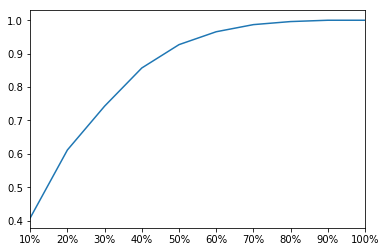

In [33]:
merge_aucs.mean(axis=1).plot()

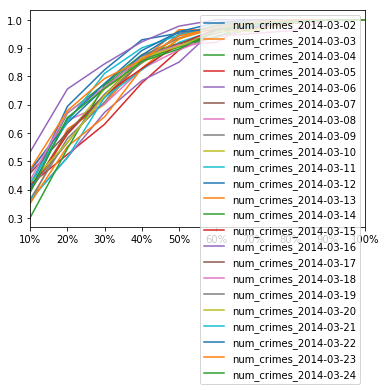

In [34]:
merge_aucs.plot()